# Round 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

## Kirk's agent

In [2]:
class Kirk_search:
    def __init__(self, board, player, cutoff = 6, debug=2):

        self.player= player
        self.maxRows= len(board)
        self.maxCols= len(board[0])
        self.cutoff = cutoff
        self.count = 0
        self.debug= debug # 1 ... count nodes, 2 ... debug each node
    
    def find_move(self, board):
        """start the search. cutoff = None is minimax search with alpha-beta pruning."""
        self.count = 0

        #TODO count number of chips on the board and set cutoff based on number
        piece_count=self.count_chips(board)
        if(piece_count<6):
            self.cutoff=6
        elif(piece_count<15):
            self.cutoff=8
        elif(piece_count<31):
            self.cutoff=10
        else:
            self.cutoff=15
        
        value, move = self.max_value_ab(board, -math.inf, +math.inf, 0)

        if self.debug >= 1: print(f"Number of nodes searched (cutoff = {self.cutoff}): {self.count}") 

        return {"move": move, "value": value}

    def max_value_ab(self, state, alpha, beta, depth):
        """player's best move."""
        self.count += 1

        # cut off and terminal test
        v, terminal = self.eval_fun(state, self.player)
        if((self.cutoff is not None and depth >= self.cutoff) or terminal): 
            if(terminal): 
                alpha, beta = v, v
            if self.debug >= 2: print(f"stopped at {depth}: {state} term: {terminal} eval: {v} [{alpha}, {beta}]" ) 
            return v, None

        v, move = -math.inf, None

        # check all possible actions in the state, update alpha and return move with the largest value
        for a in self.actions(state):
            v2, a2 = self.min_value_ab(self.result(state, self.player, a), alpha, beta, depth + 1)
            if v2 > v:
                v, move = v2, a
                alpha = max(alpha, v)
            if v >= beta: return v, move

        return v, move

    def min_value_ab(self, state, alpha, beta, depth):
        """opponent's best response."""
        self.count += 1

        # cut off and terminal test
        v, terminal = self.eval_fun(state, self.player)
        if((self.cutoff is not None and depth >= self.cutoff) or terminal): 
            if(terminal): 
                alpha, beta = v, v
            if self.debug >= 2: print(f"stopped at {depth}: {state} term: {terminal} eval: {v} [{alpha}, {beta}]" ) 
            return v, None

        v, move = +math.inf, None

        # check all possible actions in the state, update beta and return move with the smallest value
        for a in self.actions(state):
            v2, a2 = self.max_value_ab(self.result(state, self.other(self.player), a), alpha, beta, depth + 1)
            if v2 < v:
                v, move = v2, a
                beta = min(beta, v)
            if v <= alpha: return v, move
        return v, move
    
    #gets non active user
    def other(self, player): 
        if player == 1: return -1
        else: return 1
    
    #returns possible moves using move ordering
    def actions(self,s):
        #get not full collumns
        actions = np.where(np.array(s[0])==0)[0].tolist()
        #prioritize center columns
        priority = [1,2,3,4,3,2,1]
        priority = [priority[i] for i in actions]

        return [a for _,a in sorted(zip(priority,actions), reverse=True)]

    #updates board with move
    def result(self, s, p, a):
        #check if column is full
        if(s[0][a] != 0):
            print("Error: Illegal move!")
        #copy board
        board = np.copy(s)
        #find lowest row
        lowestRow=0
        for lowestRow in range(self.maxRows):
            #if player disc is found
            if(board[lowestRow][a]!=0):
                #place player disc one above current disc
                board[lowestRow-1][a]=p
                #return board   
                return board
        #place player disc on lowest row
        board[lowestRow][a]=p
        #return board   
        return board

    #checks if the board is full
    def terminal(self, s):
        #search board and check if it is full
        for i in range(len(s)):
            for j in range(len(s[0])):
                if s[i][j] ==0: return False
        return True

    #checks if a player has won
    def check_win(self, s):
        #copy board
        board = np.copy(s)
        #search board
        for i in range(self.maxRows):
            for j in range(self.maxCols):
                #check vertical
                if not i + 3 >= self.maxRows and board[i][j]  == board[i+1][j] == board[i+2][j] == board[i+3][j] !=0:
                    return board[i][j]
                #check horizontal
                if not j + 3 >= self.maxCols and board[i][j]  == board[i][j+1] == board[i][j+2] == board[i][j+3] !=0:
                    return board[i][j]
                #check diagonal
                if not j + 3 >= self.maxCols and not i + 3 >= self.maxRows and board[i][j] == board[i+1][j + 1] == board[i+2][j + 2] == board[i+3][j + 3] !=0:
                    return board[i][j]
                #check reverse diagonal
                if not j - 3 < 0 and not i + 3 >= self.maxRows and board[i][j] == board[i+1][j - 1] == board[i+2][j - 2] == board[i+3][j - 3] !=0:
                    return board[i][j]
        #return 0 if no winner
        return 0

    #checks for winner/tie/game not over
    def utility(self, s, player = 1):
        #check if either player won
        goal = self.check_win(s)
        if goal == player: return +1 
        if goal == self.other(player): return -1
        #check if board is full
        draw = self.terminal(s)
        if draw: return 0
        #if game is not over
        return None
    
    #checks if the board is full
    def count_chips(self, s):
        counter=0
        #search board and check if it is full
        for i in range(len(s)):
            for j in range(len(s[0])):
                if s[i][j] !=0: counter+=0
        return counter

    def check_alone(self,board, player, r, c):
        #check top left row
        if r>0 and c>0 and board[r-1][c-1]==player:
            return 0
        #check top middle row    
        if r>0 and board[r-1][c]==player:
            return 0
        #check top right row
        if r>0 and not c + 1 >= self.maxCols and board[r-1][c+1]==player:
            return 0
        #check left
        if c>0 and board[r][c-1]==player:
            return 0
        #check right
        if not c + 1 >= self.maxCols and board[r][c+1]==player:
            return 0
        #check bottom left row
        if not r + 1 >= self.maxRows and c>0 and board[r+1][c-1]==player:
            return 0
        #check bottom middle row
        if not r + 1 >= self.maxRows and board[r+1][c]==player:
            return 0
        #check bottom left row
        if not r + 1 >= self.maxRows and  not c + 1 >= self.maxCols and board[r+1][c+1]==player:
            return 0   
        #if alone, return value based on column position
        if c==3: return .000002
        elif c==2 or c==4: return .0000012
        elif c==1 or c==5: return .0000007
        elif c==0 or c==6: return .0000004

    #TODO maybe add scores for more spaces after 2 in a row
    def eval_fun(self, board, player):

        # terminal state? aka 4 in a row
        u = self.utility(board, player)
        if u is not None: return u, True

        score = 0
        #go through board
        for r in range(self.maxRows):
            for c in range(self.maxCols):
    #DIAGONAL CHECK
                #check diagonal for 3 in a row
                if not r + 2 >= self.maxRows and not c + 2 >= self.maxCols:
                    #get row
                    row = np.array([board[r][c], board[r+1][c+1], board[r+2][c+2]])
                    #check for 3 in a row for player
                    if sum(row == player) == 3:
                        #check if before and after 3 is empty [0,1,1,1,0]
                        if (c>0 and r>0 and board[r-1][c-1]==0) and (not c + 3 >= self.maxCols and not r + 3 >= self.maxRows and board[r+3][c+3]==0):
                            return player, False
                        #check if before 3 is empty [0,1,1,1]
                        elif (c>0 and r>0 and board[r-1][c-1]==0):
                            score+=.009
                        #check if after 3 is empty [1,1,1,0]
                        elif (not c + 3 >= self.maxCols and not r + 3 >= self.maxRows and board[r+3][c+3]==0):
                            score+=.009           
                    #check for 3 in a row for other player       
                    elif sum(row == self.other(player)) == 3:
                        #check if before and after 3 is empty [0,1,1,1,0]
                        if (c>0 and r>0 and board[r-1][c-1]==0) and (not c + 3 >= self.maxCols and not r + 3 >= self.maxRows and board[r+3][c+3]==0):
                            return self.other(player), False
                        #check if before 3 is empty [0,1,1,1]
                        elif (c>0 and r>0 and board[r-1][c-1]==0):
                            score-=.009
                        #check if after 3 is empty [1,1,1,0]
                        elif (not c + 3 >= self.maxCols and not r + 3 >= self.maxRows and board[r+3][c+3]==0):
                            score-=.009    
                #check diagonal for 2 in a row
                if not r + 1 >= self.maxRows and not c + 1 >= self.maxCols:
                    #get row
                    row = np.array([board[r][c], board[r+1][c+1]])
                    #check for 2 in a row
                    if sum(row == player) == 2:
                        #make sure its not 3 in a row
                        if not (c>0 and r>0 and board[r-1][c-1]==player) and not (not c + 2 >= self.maxCols and not r + 2 >= self.maxRows and board[r+2][c+2]==player):
                            #check if before and after 2 is empty [0,1,1,0]
                            if (c>0 and r>0 and board[r-1][c-1]==0) and (not c + 2 >= self.maxCols and not r + 2 >= self.maxRows and board[r+2][c+2]==0):
                                #check if next before is same player [1,0,1,1,0]
                                if (c>1 and r>1 and board[r-2][c-2]==player):
                                    score+=.009
                                #check if next after is same player [0,1,1,0,1]
                                elif (not c + 3 >= self.maxCols and not r + 3 >= self.maxRows and board[r+3][c+3]==player):
                                    score+=.009
                                else: score+=.0005
                            #check if before 2 is empty [0,1,1]
                            elif (c>0 and r>0 and board[r-1][c-1]==0):
                                #check if next before is same player [1,0,1,1]
                                if (c>1 and r>1 and board[r-2][c-2]==player):
                                    score+=.009
                                else: score+=.0001
                            #check if after 2 is empty [1,1,0]
                            elif (not c + 2 >= self.maxCols and not r + 2 >= self.maxRows and board[r+2][c+2]==0):
                                #check if next after is same player [1,1,0,1]
                                if (not c + 3 >= self.maxCols and not r + 3 >= self.maxRows and board[r+3][c+3]==player):
                                    score+=.009
                                else: score+=.0001   
                    #check for 2 in a row for other player
                    elif sum(row == self.other(player)) == 2:
                        #make sure its not 3 in a row
                        if not (c>0 and r>0 and board[r-1][c-1]==self.other(player)) and not (not c + 2 >= self.maxCols and not r + 2 >= self.maxRows and board[r+2][c+2]==self.other(player)):
                            #check if before and after 2 is empty [0,1,1,0]
                            if (c>0 and r>0 and board[r-1][c-1]==0) and (not c + 2 >= self.maxCols and not r + 2 >= self.maxRows and board[r+2][c+2]==0):
                                #check if next before is same player [1,0,1,1,0]
                                if (c>1 and r>1 and board[r-2][c-2]==self.other(player)):
                                    score-=.009
                                #check if next after is same player [0,1,1,0,1]
                                elif (not c + 3 >= self.maxCols and not r + 3 >= self.maxRows and board[r+3][c+3]==self.other(player)):
                                    score-=.009
                                else: score-=.0005
                            #check if before 2 is empty [0,1,1]
                            elif (c>0 and r>0 and board[r-1][c-1]==0):
                                #check if next before is same player [1,0,1,1]
                                if (c>1 and r>1 and board[r-2][c-2]==self.other(player)):
                                    score-=.009
                                else: score-=.0001
                            #check if after 2 is empty [1,1,0]
                            elif (not c + 2 >= self.maxCols and not r + 2 >= self.maxRows and board[r+2][c+2]==0):
                                #check if next after is same player [1,1,0,1]
                                if (not c + 3 >= self.maxCols and not r + 3 >= self.maxRows and board[r+3][c+3]==self.other(player)):
                                    score-=.009
                                else: score-=.0001
    #REVERSE DIAGONAL CHECK
                #check diagonal for 3 in a row
                if not r + 2 >= self.maxRows and c>1:
                    #get row
                    row = np.array([board[r][c], board[r+1][c-1], board[r+2][c-2]])
                    #check for 3 in a row for player
                    if sum(row == player) == 3:
                        #check if before and after 3 is empty [0,1,1,1,0]
                        if (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==0) and (c>2 and not r + 3 >= self.maxRows and board[r+3][c-3]==0):
                            return player, False
                        #check if before 3 is empty [0,1,1,1]
                        elif (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==0):
                            score+=.009
                        #check if after 3 is empty [1,1,1,0]
                        elif (c>2 and not r + 3 >= self.maxRows and board[r+3][c-3]==0):
                            score+=.009
                    #check for 3 in a row for other player
                    elif sum(row == self.other(player)) == 3:
                        #check if before and after 3 is empty [0,1,1,1,0]
                        if (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==0) and (c>2 and not r + 3 >= self.maxRows and board[r+3][c-3]==0):
                            return self.other(player), False
                        #check if before 3 is empty [0,1,1,1]
                        elif (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==0):
                            score-=.009
                        #check if after 3 is empty [1,1,1,0]
                        elif (c>2 and not r + 3 >= self.maxRows and board[r+3][c-3]==0):
                            score-=.009  
                #check diagonal for 2 in a row
                if not r + 1 >= self.maxRows and c>0:
                    #get row
                    row = np.array([board[r][c], board[r+1][c-1]])
                    #check for 2 in a row
                    if sum(row == player) == 2:
                        #make sure its not 3 in a row
                        if not (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==player) and not (c>1 and not r + 2 >= self.maxRows and board[r+2][c-2]==player):
                            #check if before and after 2 is empty [0,1,1,0]
                            if (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==0) and (c>1 and not r + 2 >= self.maxRows and board[r+2][c-2]==0):
                                #check if next before is same player [1,0,1,1,0]
                                if (not c + 2 >= self.maxCols and r>1 and board[r-2][c+2]==player):
                                    score+=.009
                                #check if next after is same player [0,1,1,0,1]
                                elif (c>2 and not r + 3 >= self.maxRows and board[r+3][c-3]==player):
                                    score+=.009
                                else: score+=.0005
                            #check if before 2 is empty [0,1,1]
                            elif (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==0):
                                #check if next before is same player [1,0,1,1]
                                if (not c + 2 >= self.maxCols and r>1 and board[r-2][c+2]==player):
                                    score+=.009
                                else: score+=.0001
                            #check if after 2 is empty [1,1,0]
                            elif (c>1 and not r + 2 >= self.maxRows and board[r+2][c-2]==0):
                                #check if next after is same player [1,1,0,1]
                                if (c>2 and not r + 3 >= self.maxRows and board[r+3][c-3]==player):
                                    score+=.009
                                else: score+=.0001  
                    #check for 2 in a row for other player
                    elif sum(row == self.other(player)) == 2:
                        #make sure its not 3 in a row
                        if not (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==self.other(player)) and not (c>1 and not r + 2 >= self.maxRows and board[r+2][c-2]==self.other(player)):
                            #check if before and after 2 is empty [0,1,1,0]
                            if (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==0) and (c>1 and not r + 2 >= self.maxRows and board[r+2][c-2]==0):
                                #check if next before is same player [1,0,1,1,0]
                                if (not c + 2 >= self.maxCols and r>1 and board[r-2][c+2]==self.other(player)):
                                    score-=.009
                                #check if next after is same player [0,1,1,0,1]
                                elif (c>2 and not r + 3 >= self.maxRows and board[r+3][c-3]==self.other(player)):
                                    score-=.009
                                else: score-=.0005
                            #check if before 2 is empty [0,1,1]
                            elif (not c + 1 >= self.maxCols and r>0 and board[r-1][c+1]==0):
                                #check if next before is same player [1,0,1,1]
                                if (not c + 2 >= self.maxCols and r>1 and board[r-2][c+2]==self.other(player)):
                                    score-=.009
                                else: score-=.0001
                            #check if after 2 is empty [1,1,0]
                            elif (c>1 and not r + 2 >= self.maxRows and board[r+2][c-2]==0):
                                #check if next after is same player [1,1,0,1]
                                if (c>2 and not r + 3 >= self.maxRows and board[r+3][c-3]==self.other(player)):
                                    score-=.009
                                else: score-=.0001
    #VERTICAL CHECK
                #check vertical for 3 in a row
                if not r + 2 >= self.maxRows:
                    #get row
                    row = np.array([board[r][c], board[r+1][c], board[r+2][c]])
                    #check for 3 in a row for player and before 3 is empty [0,1,1,1]
                    if sum(row == player) == 3 and r>0 and board[r-1][c]==0:
                        score+=.009
                    #check for 3 in a row for other player and before 3 is empty [0,1,1,1]
                    elif sum(row == self.other(player)) == 3 and r>0 and board[r-1][c]==0:
                        score-=.009                              
                #check vertical for 2 in a row
                if not r + 1 >= self.maxRows:
                    #get row
                    row = np.array([board[r][c], board[r+1][c]])
                    #check for 2 in a row
                    if sum(row == player) == 2:
                        #make sure its not 3 in a row
                        if not (r>0 and board[r-1][c]==player) and not (not r + 2 >= self.maxRows and board[r+2][c]==player):
                            #make sure before is empty
                            if r>0 and board[r-1][c]==0:
                                score+=.0001
                    #check for 2 in a row for other player
                    elif sum(row == self.other(player)) == 2:
                        #make sure its not 3 in a row
                        if not (r>0 and board[r-1][c]==self.other(player)) and not (not r + 2 >= self.maxRows and board[r+2][c]==self.other(player)):
                            #make sure before is empty
                            if r>0 and board[r-1][c]==0:
                                score-=.0001
    #HORIZONTAL CHECK
                #check horizontal for 3 in a row
                if not c + 2 >= self.maxCols:
                    #get row
                    row = np.array([board[r][c], board[r][c+1], board[r][c+2]])
                    #check for 3 in a row for player
                    if sum(row == player) == 3:
                        #check if before and after 3 is empty [0,1,1,1,0]
                        if (c>0 and board[r][c-1]==0) and (not c + 3 >= self.maxCols and board[r][c+3]==0):
                            return player, False
                        #check if before 3 is empty [0,1,1,1]
                        elif (c>0 and board[r][c-1]==0):
                            score+=.009
                        #check if after 3 is empty [1,1,1,0]
                        elif (not c + 3 >= self.maxCols and board[r][c+3]==0):
                            score+=.009           
                    #check for 3 in a row for other player       
                    elif sum(row == self.other(player)) == 3:
                        #check if before and after 3 is empty [0,1,1,1,0]
                        if (c>0 and board[r][c-1]==0) and (not c + 3 >= self.maxCols and board[r][c+3]==0):
                            return self.other(player), False
                        #check if before 3 is empty [0,1,1,1]
                        elif (c>0 and board[r][c-1]==0):
                            score-=.009
                        #check if after 3 is empty [1,1,1,0]
                        elif (not c + 3 >= self.maxCols and board[r][c+3]==0):
                            score-=.009          
                #check horizontal for 2 in a row
                if not c + 1 >= self.maxCols:
                    #get row
                    row = np.array([board[r][c], board[r][c+1]])
                    #check for 2 in a row
                    if sum(row == player) == 2:
                        #make sure its not 3 in a row
                        if not (c>0 and board[r][c-1]==player) and not (not c + 2 >= self.maxCols and board[r][c+2]==player):
                            #check if before and after 2 is empty [0,1,1,0]
                            if (c>0 and board[r][c-1]==0) and (not c + 2 >= self.maxCols and board[r][c+2]==0):
                                #check if next before is same player [1,0,1,1,0]
                                if (c>1 and board[r][c-2]==player):
                                    score+=.009
                                #check if next after is same player [0,1,1,0,1]
                                elif (not c + 3 >= self.maxCols and board[r][c+3]==player):
                                    score+=.009
                                else: score+=.0005
                            #check if before 2 is empty [0,1,1]
                            elif (c>0 and board[r][c-1]==0):
                                #check if next before is same player [1,0,1,1]
                                if (c>1 and board[r][c-2]==player):
                                    score+=.009
                                else: score+=.0001
                            #check if after 2 is empty [1,1,0]
                            elif (not c + 2 >= self.maxCols and board[r][c+2]==0):
                                #check if next after is same player [1,1,0,1]
                                if (not c + 3 >= self.maxCols and board[r][c+3]==player):
                                    score+=.009
                                else: score+=.0001           
                    #check for 2 in a row for other player
                    elif sum(row == self.other(player)) == 2:
                        #make sure its not 3 in a row
                        if not (c>0 and board[r][c-1]==self.other(player)) and not (not c + 2 >= self.maxCols and board[r][c+2]==self.other(player)):
                            #check if before and after 2 is empty [0,1,1,0]
                            if (c>0 and board[r][c-1]==0) and (not c + 2 >= self.maxCols and board[r][c+2]==0):
                                #check if next before is same player [1,0,1,1,0]
                                if (c>1 and board[r][c-2]==self.other(player)):
                                    score-=.009
                                #check if next after is same player [0,1,1,0,1]
                                elif (not c + 3 >= self.maxCols and board[r][c+3]==self.other(player)):
                                    score-=.009
                                else: score-=.0005
                            #check if before 2 is empty [0,1,1]
                            elif (c>0 and board[r][c-1]==0):
                                #check if next before is same player [1,0,1,1]
                                if (c>1 and board[r][c-2]==self.other(player)):
                                    score-=.009
                                else: score-=.0001
                            #check if after 2 is empty [1,1,0]
                            elif (not c + 2 >= self.maxCols and board[r][c+2]==0):
                                #check if next after is same player [1,1,0,1]
                                if (not c + 3 >= self.maxCols and board[r][c+3]==self.other(player)):
                                    score-=.009
                                else: score-=.0001
    #ALONE CHECK
                #check if square is not connected
                if board[r][c]!=0:
                    score+=self.check_alone(board, player, r, c)
                    score-=self.check_alone(board, self.other(player), r, c)
        #return final score
        return score, False

In [3]:
def kirk_player(board, player = 1, debug=0):
    heuristic_player=Kirk_search(board=board, player=player, debug=debug)
    return heuristic_player.find_move(board)

## ___'s agent

In [4]:
#insert opponent agent class here

In [5]:
#insert opponent agent find move function here

## Game Time!

In [6]:
import matplotlib.pyplot as plt
    
#visualizes board
def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

### Game 1
**Player 1:**

**Player 2:**

In [7]:
from environment import truly_dynamic_environment,replay
playerz = [
    {
        "algo": ,
        "player":1,
        "args":{}
    },
    {
        "algo":,
        "player":-1,
        "args":{}
    }
]

result,final_board,all_boards = truly_dynamic_environment(playerz,size=(6,7),visual=True)

kirk_player Took a total of: 31.59 seconds
sanjay_player Took a total of: 0.04 seconds


In [8]:
print(result)

{'algo_info': {'kirk_player': {'time': [5608.662299999999, 7788.198700000003, 8658.4164, 7261.074899999997, 2277.395999999996]}, 'sanjay_player': {'time': [15.174800000000488, 12.358799999997672, 8.834700000001305, 6.561800000000062]}}, 'winner': 1, 'turns_taken': 9}


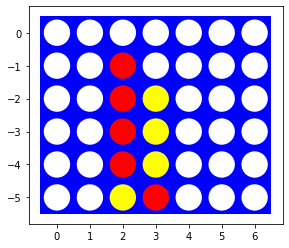

In [9]:
visualize(final_board)

### Game 2
**Player 1:** Sanjay

**Player 2:** Kirk

In [10]:
from environment import truly_dynamic_environment,replay
playerz = [
    {
        "algo":sanjay_player,
        "player":1,
        "args":{}
    },
    {
        "algo":kirk_player,
        "player":-1,
        "args":{}
    }
]

result,final_board,all_boards = truly_dynamic_environment(playerz,size=(6,7),visual=True)

sanjay_player Took a total of: 0.08 seconds
kirk_player Took a total of: 95.42 seconds


In [11]:
print(result)

{'algo_info': {'sanjay_player': {'time': [8.112199999999348, 11.717799999999556, 10.985500000003867, 11.674399999996865, 9.640000000004534, 8.609300000003373, 9.178300000002082, 7.385900000002721, 4.111999999992122, 2.2634000000039123]}, 'kirk_player': {'time': [13480.9233, 6277.3099999999995, 7809.696199999998, 31489.0453, 31234.1744, 4324.893000000003, 526.2993000000051, 167.0804999999973, 112.37330000000156]}}, 'winner': 1, 'turns_taken': 19}


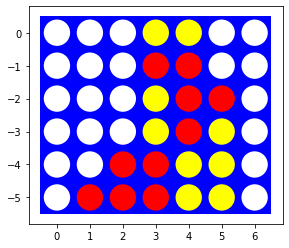

In [12]:
visualize(final_board)

**Final winner:** Kirk

**NOTE:** would have lost to opponent if they used cutoff value of 3.